## Transfer Learning

(based on a tutorial by Python Engineer in Youtube)

Transfer learning is a machine learning method where a model developed for a first task is then reused as the starting point for a model on a second task.
For example we can train a model to classify cats and dogs and then use it (with a few modification in its last layer) to classify cars and ships.
Using pretrained model saves us time.

Here we are going to use a pretrained RESNET18 (18 layers deep and can classify images into 1000 categories) CNN to classify bees and ants.

New concepts of this tutorial:

In [131]:
#ImageFolder >> dataset
#Scheduler >> to change the learning rate
#Transfer Learning

In [207]:
#import libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets,models,transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [208]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [209]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

In [210]:
data_transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
        ]),
}

In [211]:
#import data
data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                         data_transform[x])
                 for x in ['train','val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=0)
               for x in ['train','val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}

class_names = image_datasets['train'].classes
print(class_names)

['ants', 'bees']


In [212]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

In [213]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fba4a1a8460>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7fba4a1a80d0>}

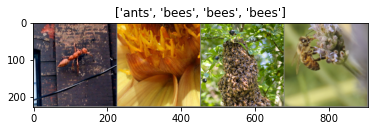

In [214]:

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [187]:
def train_model(model, criterion, optimizer, schedualer, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'epoch {epoch}/{num_epochs-1}')
        print('-'*10)
        
        #each epoch has a training and validation phase
        for phase in ['train','val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
           
            running_loss = 0.0
            running_corrects = 0
            
            print(phase)
            
            #iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                #forward
                #track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    
                    #backward + optimize only in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        
                    #statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
                if phase == 'train':
                    schedualer.step()
                
                
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                
                #deep copy the model
                if phase == 'val'and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
            
            print()
        
        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed*60:.0f}s')
        print(f'Best val Acc: {best_acc:.4f}')
        
        #load best model weights
        model.load_state_dict(best_model_wts)
        return model

In [188]:
# now let's use transfer learning
#first option, this is called fine-tuning because here we train the model again but only a little bit so we finetune
#all the weights based on the new data and with a new last layer.

model = torchvision.models.resnet18(pretrained=True) #the optimizer weights that are trained on imageNet data

#exchange the last fully connected layer

#first we get the number of input features from the last layer
num_ftrs = model.fc.in_features

#now let's create a new layer and assign it to the last layer
model.fc = nn.Linear(num_ftrs, 2)
model.to(device)

#define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001)


#scheduler = update the learning rate
step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 7 , gamma = 0.1)
# every 7(step) epochs the lr will be multiplied by gamma


In [189]:
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=20)

epoch 0/19
----------
train
train Loss: 0.0147 Acc: 0.0082
train Loss: 0.0296 Acc: 0.0123
train Loss: 0.0399 Acc: 0.0246
train Loss: 0.0520 Acc: 0.0328
train Loss: 0.0674 Acc: 0.0369
train Loss: 0.0795 Acc: 0.0451
train Loss: 0.0954 Acc: 0.0492
train Loss: 0.1067 Acc: 0.0533
train Loss: 0.1143 Acc: 0.0697
train Loss: 0.1292 Acc: 0.0779
train Loss: 0.1434 Acc: 0.0820
train Loss: 0.1521 Acc: 0.0943
train Loss: 0.1611 Acc: 0.1066
train Loss: 0.1732 Acc: 0.1148
train Loss: 0.1870 Acc: 0.1189
train Loss: 0.1942 Acc: 0.1352
train Loss: 0.2037 Acc: 0.1475
train Loss: 0.2181 Acc: 0.1516
train Loss: 0.2303 Acc: 0.1639
train Loss: 0.2390 Acc: 0.1803
train Loss: 0.2498 Acc: 0.1926
train Loss: 0.2594 Acc: 0.2049
train Loss: 0.2724 Acc: 0.2172
train Loss: 0.2847 Acc: 0.2254
train Loss: 0.2948 Acc: 0.2336
train Loss: 0.3078 Acc: 0.2377
train Loss: 0.3212 Acc: 0.2459
train Loss: 0.3317 Acc: 0.2541
train Loss: 0.3431 Acc: 0.2623
train Loss: 0.3527 Acc: 0.2746
train Loss: 0.3660 Acc: 0.2787
train Loss:

In [190]:
#second option more faster
#freeze all the layers in the beginning and train the very last layers


model = torchvision.models.resnet18(pretrained=True) #the optimizer weights that are trained on imageNet data

for param in model.parameters():
    #freeze all the layers in the beginning
    param.requires_grad = False
    
    
#exchange the last fully connected layer

#first we get the number of input features from the last layer
num_ftrs = model.fc.in_features

#now let's create a new layer and assign it to the last layer
model.fc = nn.Linear(num_ftrs, 2)
model.to(device)

#define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001)


#scheduler = update the learning rate
step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 7 , gamma = 0.1)
# every 7(step) epochs the lr will be multiplied by gamma

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=20)

epoch 0/19
----------
train
train Loss: 0.0197 Acc: 0.0041
train Loss: 0.0379 Acc: 0.0082
train Loss: 0.0506 Acc: 0.0164
train Loss: 0.0615 Acc: 0.0246
train Loss: 0.0712 Acc: 0.0369
train Loss: 0.0833 Acc: 0.0451
train Loss: 0.0946 Acc: 0.0533
train Loss: 0.1089 Acc: 0.0533
train Loss: 0.1165 Acc: 0.0697
train Loss: 0.1280 Acc: 0.0820
train Loss: 0.1396 Acc: 0.0902
train Loss: 0.1518 Acc: 0.0984
train Loss: 0.1611 Acc: 0.1107
train Loss: 0.1722 Acc: 0.1189
train Loss: 0.1820 Acc: 0.1311
train Loss: 0.1915 Acc: 0.1434
train Loss: 0.2041 Acc: 0.1475
train Loss: 0.2134 Acc: 0.1557
train Loss: 0.2259 Acc: 0.1680
train Loss: 0.2369 Acc: 0.1762
train Loss: 0.2488 Acc: 0.1844
train Loss: 0.2599 Acc: 0.1926
train Loss: 0.2712 Acc: 0.2049
train Loss: 0.2819 Acc: 0.2172
train Loss: 0.2941 Acc: 0.2254
train Loss: 0.3096 Acc: 0.2295
train Loss: 0.3210 Acc: 0.2377
train Loss: 0.3322 Acc: 0.2459
train Loss: 0.3450 Acc: 0.2541
train Loss: 0.3569 Acc: 0.2623
train Loss: 0.3673 Acc: 0.2746
train Loss: